# Proyecto "Ice" Tienda online de videojuegos

## Descripcion del proyecto
La tienda online Ice vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. EL objetivo general del proyecto consiste en identificar patrones que determinen si un juego tiene éxito o no. Esto nos permitirá detectar proyectos prometedores y planificar campañas publicitarias.Estaremos trabajando con datos que se remontan a 2016. La compañia esta planeando una campaña para 2017.

El dataset maneja la clasificación ESRB para cada juego, que corresponde a "The Entertainment Software Rating Board" (la Junta de clasificación de software de entretenimiento), misma que evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto

Para lograr los objetivos, vamos a preparar los datos recibidos y luego analizarlos con el fin de crear un perfil de usuario para cada región (Norteamerica, la Union Europea y Japón).

Por ultimo buscaremos responder a las siguientes hipótesis: 
- Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.
- Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [13]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from scipy.stats import ttest_ind 

## 1. Dataset principal "games"

Lectura e información general 

In [14]:
games = pd.read_csv('/datasets/games.csv')

In [15]:
display(games.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


El dataset contiene 11 columnas y 16,715 entradas. Los nombres de las columnas estan en formato de mayúscula incial y todos corresponden a la información que contienen. Hay valores ausentes en 6 columnas (name, year_of_realase, genre, critic_score, user_score y rating). Se considera que el tipo de datos de las columna year_of_release, critic_score y user_score no corresponden con los datos que almacenan. 

## 2. Preparar los datos

1. Reemplazar los nombres de las columnas.
2. Convertir los datos en los tipos necesarios.
3. Describir las columnas en las que los tipos de datos han sido cambiados y explicar por qué.
4. Si es necesario, elegir la manera de tratar los valores ausentes:
    1. Explicar por qué se van a rellenar los valores ausentes o por qué dejarlos en blanco.
    2. ¿Cual es la posible razón de que los valores están ausentes?
    3. Especificar como se van a manejar los casos donde se presente la abreviatura TBD ("to be determined" / a determinar).
5. Calcular las ventas totales (la suma de las ventas en todas las regiones) para cada juego y colocar estos valores en una columna separada.

In [17]:
# convertir el nombre de las columnas a minúsculas
games.columns = games.columns.str.lower()

### 2.2 y 2.3 Tipos de datos

In [18]:
# convertir year_of_release a tipo numerico entero dejando los NaN
games['year_of_release'] = pd.to_numeric(games['year_of_release'], errors='coerce').astype('Int64')

# convertir year_of_release a tipo numerico entero dejando los NaN
games['critic_score'] = pd.to_numeric(games['critic_score'], errors='coerce').astype('Int64')

# convertir user_score a tipo numérico, manejando los errores como NaN
games['user_score'] = pd.to_numeric(games['user_score'], errors= 'coerce')


La columna year_of_release se cambio a un tipo de dato entero que refleja mejor la informacion que contiene correspondiente al año de lanzamiento, mismo que no sería correcto expresar con decimal. 
<br> La columna critic_score maneja puntuaciones del 0-100 sin permitir decimales. Se cambió a tipo int para mejorar el formato.
<br> Por el contrario, user_score maneja puntuaciones del 0-10 permitiendo decimales, razón por la cual se cambio de object a numeric (función que por defecto convierte a float).

En los tres casos se hizo uso de la función to_numeric para poder agregar el argumento de control de errores debido a la presencia de valores ausentes y particularmente en  la columna user_score, se detectó que el tipo de dato era object debido a la presencia del dato "tbd" (to be defined); se decidió manejar este "error" como NaN pues cualquier otro valor no definiría información certera. 

### 2.4 Revision de valores ausentes

In [19]:
# calcular el porcentaje de valores ausentes en cada columna
100 * (games.isna().sum() / games.shape[0])

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         54.591684
rating             40.478612
dtype: float64

In [20]:
# eliminar los valores ausentes en la columna name 
games.dropna(subset= ['name'], inplace=True)

# restablecer los índices debido a la eliminación 
games.reset_index(drop= True, inplace=True)

# remplazar los valores ausentes en year_of_release con la mediana
games['year_of_release'].fillna(games['year_of_release'].median(), inplace=True)

Al obtener el porcentaje de valores ausentes en las columnas name, genre y year_of_release se observó que este es considerablemente bajo por lo que se analizaron de manera individual en búsqueda de patrones. 

Las columnas name y genre presentan los NaN en las mismas 2 filas, se infirió  que ambas corresponden al mismo juego (posiblemente capturado por error dos veces con errores en ambas capturas). Ante la presencia de muy poca información en cada fila, se decidió eliminar ambas considerando que no interfiere con el análisis.
<br> Los valores ausentes en la columna year_of_release fueron remplazados con la mediana pues esta no se ve afectada por valores extremos que puedan existir en los datos. Se observaron pocos casos en donde el año fue capturado en el nombre del juego, pero en su mayoría no se detectaron patrones que den una razón posible para la ausencia de este dato. Se deberá trabajar en la base de manera externa para poder recuperarlos. 

Por otro lado, el porcentaje de valores ausentes en las columnas critic_score, user_score y rating es alto (mayor al 40%) y su remplazo crearía sesgos importantes en el análisis, por ello se decidió dejarlos en blanco. Probablemente en juegos muy antiguos estos datos no se encuentren debido a que anteriormente no existía la practica de calificar los juegos o clasificarlos en un rating; en los demás casos es posible que aún no hayan sido sometidos a la critica o en su defecto esta información si existe pero se encuentra en plataformas no unificadas, lo que dificulta su recolección. 

Además recordar que en la columna user_score aumentó el número de valores ausentes debido a la presencia del dato "tbd", mismo que fue remplazado por NaN en la conversion del tipo de dato realizada anteriormente. Estos valores posiblemente representan aquellos videojuegos que aún estan en proceso de ser calificados, o que (de acuerdo con la documentacion) por su lanzamiento reciente en 2016, la información este incompleta.






### 2.5 Calcular las ventas totales

In [21]:
# crear nueva columna con la suma total de las ventas
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [22]:
# comprobar los cambios realizados
display(games.head())

games.info()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
 11  total_sales      16713 non-null  float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.6+ MB


### Conclusiones Parte 2. Preparación de los datos

Se modificó el formato del nombre de columnas y el tipo de datos de 2 de ellas. Para la revisión de valores ausentes se eliminaron dos filas que en su mayoría contenian valores NaN y se restablecieron los índices. Se decidió dejar en blanco los valores ausentes de las columnas critic, user_score y rating debido a que rempresentaban mas del 40% de los datos y remplazarlos crearía un sesgo en el analisis. Por último se agregó una columna con las ventas totales, obtenidas de la suma de las ventas de cada región.

## 3. Análisis de los datos

1. Mostrar cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?
2. Mostrar cómo varían las ventas de una plataforma a otra. 
    - Elegir las plataformas con las mayores ventas totales y construir una distribución basada en los datos de cada año. 
    - Buscar las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?
    - Determinar para qué período se deben tomar datos mediante las respuestas a las preguntas anteriores y construir un modelo para 2017.
        <br> *Trabajar solo con los datos relevantes, ignorar los datos de años anteriores*
    - Dar respuesta a las preguntas: ¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Eligir varias plataformas potencialmente rentables.
3. Crear un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.
4. Mostrar cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (*Plataforma elegida: PS3*). Crear un gráfico de dispersión y calcular la correlación entre las reseñas y las ventas.
5. Con base en las conclusiones arrojadas en el punto anterior, comparar las ventas de los mismos juegos en otras plataformas.
6. Visualizar la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Se puede generalizar acerca de los géneros con ventas altas y bajas?

### 3.1 Videojuegos lanzados por año 

<function matplotlib.pyplot.show(close=None, block=None)>

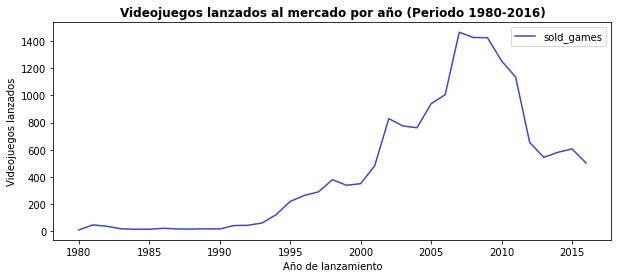

In [23]:
#Contar el numero de videojuegos por año
count_games = games.groupby('year_of_release')['name'].count().reset_index().rename({"name":"sold_games"}, axis= 'columns')

#Graficar la tendencia en el numero de videojuegos lanzados a lo largo de los años
count_games.plot(kind= 'line', x='year_of_release', y= 'sold_games', figsize= (10,4), colormap= 'coolwarm')

plt.title('Videojuegos lanzados al mercado por año (Periodo 1980-2016)', fontweight='bold')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Videojuegos lanzados')

plt.show

De 1980 a 1993 se lanzaban al mercado menos de 100 videojuegos al año. Vemos que el aumento comienza en 1998 donde se llegaron a vender 400 videjuegos en ese año, mas adelante en 2001 se duplicó esta cifra alcanzando poco mas de 800 y por ultimo el auge se da en 2006 y 2009 donde se registró el lanzamiento de poco mas de 1400 videojuegos (la cifra mas alta de videojuegos vendidos en el periodo analizado). 
<br> A partir de 2010 y hasta 2016 se observa un declive progresivo, este ultimo año obteniendo cifras menores a 600 videojuegos lanzados al mercado. 


### 3.2 Ventas por plataforma

<function matplotlib.pyplot.show(close=None, block=None)>

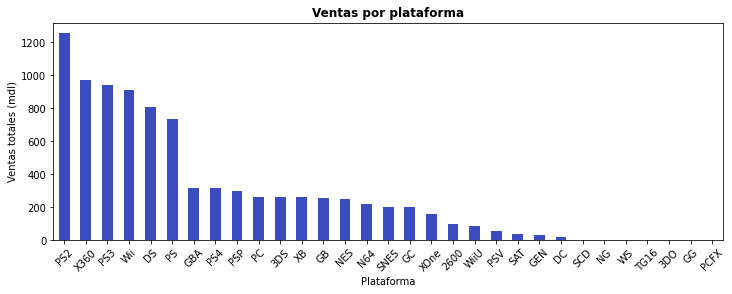

In [24]:
#Lista de las plataformas y la suma de sus ventas empezando con la plataforma líder en ventas 
platform_sales = games.groupby('platform')['total_sales'].sum().reset_index().sort_values(by='total_sales', ascending= False)

#Gráfico de ventas por plataforma
platform_sales.plot(kind='bar', x='platform', y='total_sales', 
                    figsize= (12,4), 
                    legend= False,
                    colormap= 'coolwarm')

plt.title('Ventas por plataforma', fontweight='bold')
plt.xlabel('Plataforma')
plt.ylabel('Ventas totales (mdl)')
plt.xticks(rotation=45)

plt.show

Las plataformas con mayores ventas totales recaudadas son  PS2 con ventas mayores a 1200mdl, X360, PS3, Wii, DS, con cifras mayores a 800mdl y PS con poco mas de 700mdl. Las 25 plataformas restantes registraron ventas totales por menos de 400mdl.

In [25]:
#Lista con las plataformas con mayores ventas
top_sales = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

#Filtrar tabla con las plataformas con mayores ventas
top_platforms = games[games['platform'].isin(top_sales)]

<function matplotlib.pyplot.show(close=None, block=None)>

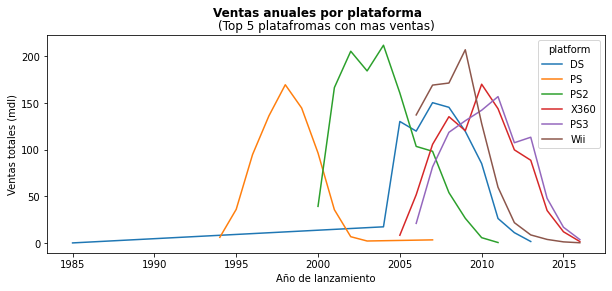

In [26]:
#Agrupar por año y plataforma y calcular las ventas totales
platform_dist = top_platforms.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

#Gráfico de tendencia anual en ventas por plataforma 
plt.figure(figsize=(10, 4))
sns.lineplot(data= platform_dist, hue= 'platform', x= 'year_of_release', y= 'total_sales')

plt.title('(Top 5 platafromas con mas ventas)')
plt.suptitle('Ventas anuales por plataforma', fontweight='bold')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas totales (mdl)')

plt.show

In [27]:
display(games[(games['platform'] == 'DS') & (games['year_of_release'] < 2004)])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15955,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,<NA>,NaN,NaN,0.02


In [28]:
games.loc[15955, 'year_of_release'] = 2007

Se detectó la presencia de un outlier en la plataforma DS posiblemente por error en la captura, se hizo una investigación y se cambio al dato real.

Las mayoria de las 6 plataformas con mas ventas totales obtuvieron sus cifras en el periodo del 2000 a 2016 a excepción de la plataforma PS cuyas ventas fueron en el periodo 1994-1998.
- La familia de PS ha sido muy exitosa; a partir de 1994 con PS quien crecio en ventas hasta alcanzar 170mdl en 1998; después la PS2 lanzada en el 2000 tuvo un periodo creciente en ventas de 4 años alcanzando poco mas de 200mdl anuales, pero a partir de 2004 tuvo su caída y dejo de registrar ventas en 2007. Le siguio PS3 lanzado en 2006 y teniendo su pico de de ventas en 2011 (160mdl).
- La consola X360 fue lanzada en 2005 y registró su punto mas alto de ventas (170mdl) en 2010 registrando ventas mínimas en la actualidad. 
- La consola Wii se lanzo al mercado en 2006 y logro vender poco mas de 200mdl anuales en 2009, año a partir del cual empezo su declive en ventas.
- DS fue lanzada en 2004 y sus ventas mas grandes las logró con los juegos vendidos en 2007 y 2008 con casi 150mdl en ambos años. 

#### Conclusiones del punto 3.2
De acuerdo con el análisis de los videojuegos lanzados al mercado a lo largo de los años y las ventas recaudadas por las diferentes plataformas, se tomarán en cuenta unicamente los datos de juegos lanzados a partir del año 2000 en adelante, periodo en el que se observa el mayor crecimiento y que aporta mayor información para prospecciones del próximo año 2017. 
<br> En este periodo, las plataformas que han registrado mayores ventas totales son PS2, X360, PS3, Wii y DS, en ese orden, todas ellas alcanzando ventas totales de entre 800 y 1200mdl.
<br> Si bien estas plataformas han tenido los picos de ventas mas altos, tambien en todas ellas se ha observado un decrecimiento. 
<br> La plataforma PS y sus lanzamientos consecuentes es una de las mas prometedoras.
<br> Los anõs con mayor lanzamiento de videojuegos al mercado fue de 2005 a 2010.
<br> El perido de auge en ventas que tiene cada plataforma es de 5 años máximo.


### 3.3 Ventas globales de las principales plataformas


<function matplotlib.pyplot.show(close=None, block=None)>

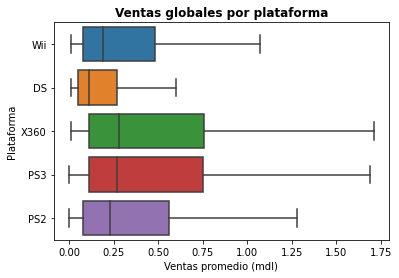

In [29]:
#Nueva lista de las plataformas con mas ventas
new_top_sales = ['PS2', 'X360', 'PS3', 'Wii', 'DS']

#Tabla nueva de plataformas con mas ventas
top_platforms = games[games['platform'].isin(new_top_sales)]

#Grafico de cajas de ventas globales por plataforma
sns.boxplot(data= top_platforms, x= 'total_sales', y= 'platform', showfliers= False)

plt.title('Ventas globales por plataforma', fontweight='bold')
plt.xlabel('Ventas promedio (mdl)')
plt.ylabel('Plataforma')

plt.show


Text(0, 0.5, 'Plataforma')

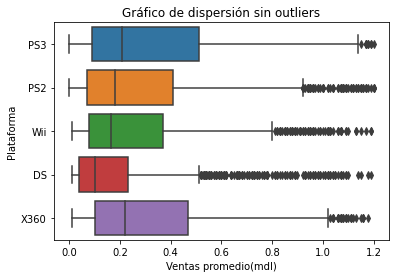

In [30]:
Q1 = top_platforms['total_sales'].quantile(0.25)
Q3 = top_platforms['total_sales'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para los valores aceptables
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los datos para excluir los outliers
tips_filtrados = top_platforms[(top_platforms['total_sales'] >= limite_inferior) & (top_platforms['total_sales'] <= limite_superior)]

# Crear el gráfico de dispersión con los datos filtrados
sns.boxplot(data=tips_filtrados, y="platform", x="total_sales")
plt.title('Gráfico de dispersión sin outliers')
plt.xlabel('Ventas promedio(mdl)')
plt.ylabel('Plataforma')

En el primer gráfico se observo la presencia de muchos valores outliers y se ocultaron, en el segundo gráfico se hizo uso del rango intercuartilico y si bien aun se observan outliers en el gráfico en ambos se muestran algunas diferencias. Por ejemplo las ventas entre las plataformas PS3 y X360, contrario a lo observado en el punto 3.2 (donde PS2 registraba las ventas mas altas), aqui ambas se muestran como líderes en ventas, dando a entender que los valores outliers son los valores que marcaron la diferencia anteriormente. 

Se observa una diferencia significativa entre la mediana de las ventas entre las 5 plataformas, principalmente la consola DS (que es la que menores ventas registra), las consolas Wii y PS2 con medianas similares entre ambas pero diferentes a las demas. X360 y PS3 expresan ventas y medianas similares. 

### 3.4 Relación entre las reseñas de un videojuego y sus ventas

/tmp/ipykernel_32/499346370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_PS3['user_score_100'] = score_PS3['user_score'] * 10


<function matplotlib.pyplot.show(close=None, block=None)>

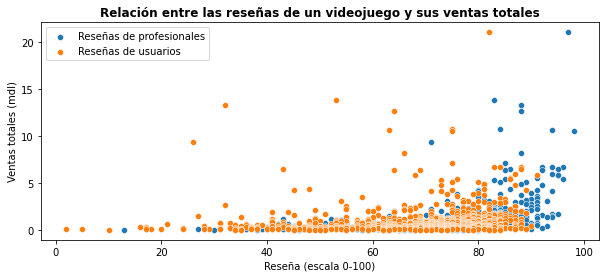

In [31]:
#Filtrar tabla con informacion de la consola PS3
score_PS3 = top_platforms[(top_platforms['platform'] == 'PS3')]

#Unificar la escala de calificacion del usuario para coincidir con la de los profesionales
score_PS3['user_score_100'] = score_PS3['user_score'] * 10

#Gráfico de dispersión de ambas reseñas
plt.figure(figsize=(10, 4))
sns.scatterplot(x='critic_score', y='total_sales', data= score_PS3, label='Reseñas de profesionales')
sns.scatterplot(x='user_score_100', y='total_sales', data= score_PS3, label='Reseñas de usuarios')

plt.title('Relación entre las reseñas de un videojuego y sus ventas totales', fontweight='bold')
plt.xlabel('Reseña (escala 0-100)')
plt.ylabel('Ventas totales (mdl)')

plt.show

In [32]:
correlation = score_PS3[['critic_score', 'user_score', 'total_sales']].corr()
print(correlation)

              critic_score  user_score  total_sales
critic_score      1.000000    0.629005     0.432432
user_score        0.629005    1.000000     0.126691
total_sales       0.432432    0.126691     1.000000


La correlación de 0.432432  sugiere que hay una relación moderadamente positiva entre las ventas totales y las reseñas de los profesionales, si bien a medida que la reseña aumenta, las ventas tienden a aumentar en cierta medida, la fuerza de esta relación no es suficientemente fuerte aunque si significativa.
<br> Respecto a la reseña de los usuarios y las ventas de la plataforma, hay una correlacion positiva de 0.126691 que indica una ligera tendencia de que las ventas totales aumenten cuando las reseñas profesionales son más altas, sin embargo esta relación es aún mas débil.

Las reseñas de los criticos parecen tener una relación más fuerte con las ventas totales en comparación con las reseñas de usuarios. Esto podría indicar que la opinión de los criticos tiene un mayor impacto en las ventas que la opinión de los usuarios. Sin embargo, hay otros factores que también pueden influir en las ventas. 

### 3.5 Ventas por juego por plataforma
Con base en las conclusiones arrojadas en el punto anterior, comparar las ventas de los mismos juegos en otras plataformas.

<function matplotlib.pyplot.show(close=None, block=None)>

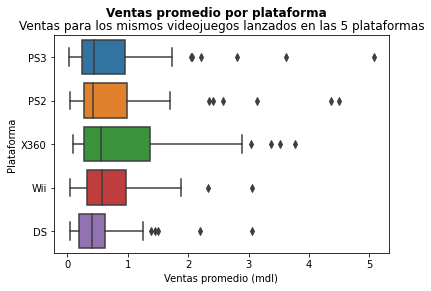

In [33]:
#Videojuegos que se venden en las mismas plataformas

games_PS3 = score_PS3['name'] #Lista de videojuegos analizados en el punto anterior de la platafroma PS3
all_games = top_platforms[top_platforms['name'].isin(games_PS3)] #Extraer los mismos videojuegos de las demás plataformas

#Videojuegos que se venden en las 5 plataformas principales
count = all_games.groupby(by= 'name').size()
games_5_platforms = count[count == 5] 

#Tabla con la información de los videojuegos de las 5 plataformas
df_5_platforms = all_games[all_games['name'].isin(games_5_platforms.index)]

#Gráfico de las ventas por plataforma
sns.boxplot(data= df_5_platforms, y= 'platform', x= 'total_sales')
plt.suptitle('Ventas promedio por plataforma', fontweight='bold')
plt.title('Ventas para los mismos videojuegos lanzados en las 5 plataformas')
plt.xlabel('Ventas promedio (mdl)')
plt.ylabel('Plataforma')

plt.show

Al comparar los mismos juegos lanzados en la consola PS3 con las demás plataformas donde tambien fueron lanzados, se observa que la consola que logro mas ventas en promedio con estos juegos fue X360. Anteriormente se había observado que la plataforma PS3 igualaba estas ventas, sin embargo el gráfico muestra que al comparar los mismos videojuegos, PS3 tiene algunos valores outliers que son los que aumentan estas ventas. La mediana de ventas es similar por lo que al menos el 50% de los videojuegos lanzados en cada plataforma caen en rangos similares. 
<br> En el punto anterior se observó que las ventas de cada videojuego podrían relacionarse con el puntaje obtenido en la critica, sin embargo para los mismos videojuegos analizados en otras platafromas, las ventas si difieren segun la plataforma donde fueron lanzadas. Siendo la mas consistente X360 y mostrando que PS3 y PS2 han alcanzado ventas altas gracias a juegos especificos. 

### 3.6 Juegos por género
Visualizar la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Se puede generalizar acerca de los géneros con ventas altas y bajas?

In [34]:
#Tabla de juegos por género y sus ventas
games_genre = top_platforms.pivot_table(values= ['name', 'total_sales'], index= 'genre', aggfunc= {"name" : "count", "total_sales" : "sum"}).reset_index()
games_genre.sort_values(by= 'total_sales', inplace= True, ascending= False)

games_genre

,genre,name,total_sales
0,Action,1628,1040.99
10,Sports,1239,865.52
8,Shooter,626,613.88
3,Misc,1145,591.37
6,Racing,572,391.66
7,Role-Playing,616,376.81
4,Platform,314,278.38
9,Simulation,531,233.10
2,Fighting,369,211.51
1,Adventure,639,122.21


<function matplotlib.pyplot.show(close=None, block=None)>

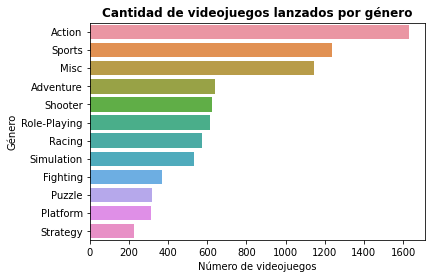

In [35]:
#Distribución del número de videojuegos por género
sns.barplot(data= games_genre.sort_values(by= 'name', ascending= False), y= 'genre', x= 'name')

plt.title('Cantidad de videojuegos lanzados por género', fontweight='bold')
plt.xlabel('Número de videojuegos')
plt.ylabel('Género')

plt.show

<AxesSubplot:xlabel='total_sales', ylabel='genre'>

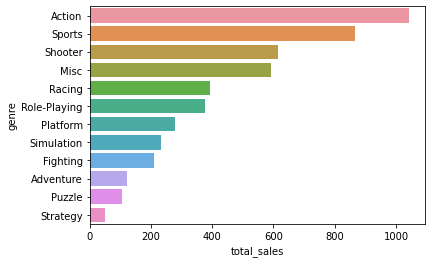

In [36]:
#Distribución de las ventas totales por género
sns.barplot(data= games_genre, y= 'genre', x= 'total_sales')

<function matplotlib.pyplot.show(close=None, block=None)>

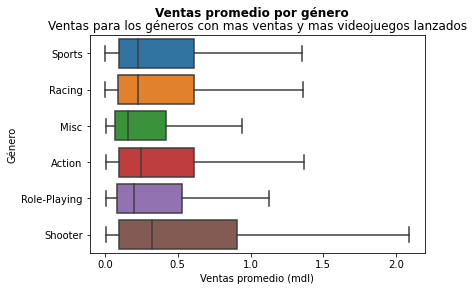

In [37]:
#Distribución de ventas por género
genre_list = ['Action', 'Sports', 'Shooter', 'Misc', 'Racing', 'Role-Playing']
top_genre = top_platforms[top_platforms['genre'].isin(genre_list)]

sns.boxplot(data= top_genre, y= 'genre', x= 'total_sales', showfliers= False)
plt.suptitle('Ventas promedio por género', fontweight='bold')
plt.title('Ventas para los géneros con mas ventas y mas videojuegos lanzados')
plt.xlabel('Ventas promedio (mdl)')
plt.ylabel('Género')

plt.show

Los generos de los cuales se han lanzado la mayor cantidad de videojuegos son Accion, Deportes, Miscelaneos, Aventura, Disparos, Juegos de Rol y Carreras.
Los generos que han registrado mayores ventas son Acción, Deportes, Disparos, Miscelaneos, Carreras y Juegos de Rol.
Al comparar las ventas promedio de los géneros que han lanzado mas videojuegos y al mismo tiempo han registrado más ventas, se detectaron muchos valores outliers, los mas grandes en el género de Deportes, Racing y Miscelaneos. Al ocultar los outliers, se observa que el género de Disparos tiene mas ventas promedio, seguido de Deportes, Carreras y Acción.  

### Conclusiones Parte 3. Analisis de los datos
El análisis de los videojuegos lanzados desde el año 2000 revela importantes tendencias y patrones en la industria. Durante este período, las plataformas líderes en ventas, como PS2, X360, PS3, Wii y DS, han experimentado un crecimiento significativo, aunque todas muestran signos de disminución en ventas. Destaca especialmente el potencial continuo de la plataforma PS, sugiriendo oportunidades prometedoras para futuros lanzamientos. Los años entre 2005 y 2010 fueron los más prolíficos en términos de lanzamientos de videojuegos al mercado. Además, se identificó un período máximo de cinco años de auge en las ventas de cada plataforma. La presencia de valores atípicos en los datos puede distorsionar la percepción real de las ventas entre plataformas, lo que indica la necesidad de un análisis más detallado y la consideración de múltiples factores. La correlación moderadamente positiva entre las ventas totales y las reseñas de los críticos sugiere que las opiniones profesionales pueden influir en las ventas, aunque las reseñas de los usuarios tienen una correlación más débil. Al comparar las mismas entregas de videojuegos en diferentes plataformas, se revela que las ventas varían significativamente según la plataforma, mostrando que la plataforma X360 ha sido la más consistente en ventas. Los géneros más populares y rentables incluyen Acción, Deportes, Disparos y Carreras, aunque la presencia de valores atípicos en algunos géneros resalta la necesidad de una comprensión más profunda de las tendencias del mercado.

## 4. Perfil de usuario por región

Para cada región (NA, UE, JP) determina:
1. Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.
2. Los cinco géneros principales. Explica la diferencia.
3. Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

### 4.1 Mercado por plataforma

In [38]:
#Ventas totales por región por plataforma
region_platforms= top_platforms.groupby(by= 'platform').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum'}).reset_index()

#Invertir el dataframe a formato largo y establecer los identificadores por region
region_platforms = pd.melt(region_platforms, id_vars= 'platform', value_vars = ['na_sales', 'eu_sales', 'jp_sales'], var_name= 'market', value_name= 'sales')
region_platforms.sort_values(by= 'sales', ascending= False, inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

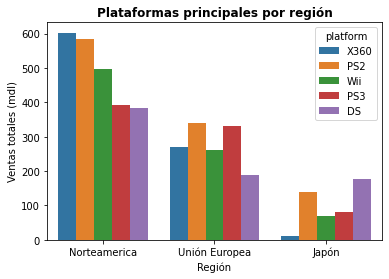

In [39]:
#Grafico de las plataformas mas populares por región
sns.barplot(x='market', y= "sales", data= region_platforms, hue= 'platform') 

plt.title('Plataformas principales por región', fontweight='bold')
plt.xlabel('Región')
plt.ylabel('Ventas totales (mdl)')

ax = plt.gca()
new_xtick = ['Norteamerica', 'Unión Europea', 'Japón']
ax.set_xticklabels(new_xtick)

plt.show

Las ventas se concentran principalmente en la región de Norteamerica, donde las plataformas con ventas mas altas son X360 y PS2 con casi 600mdl cada una; la consola Wii registra ventas de casi 500mdl y las mas bajas PS3 y DS con ventas por debajo de os 400mdl. 
<br> En la Unión Europea la familia PlayStation encabeza las ventas con PS2 y PS3 recaudando 350mdl cada una.
<br> En Japón, contrario a las anteriores, DS es la plataforma con mas ventas (200mdl), junto con PS2 (150mdl). En esta región la plataforma X360 casi no registra ventas, recaudando menos de 50mdl. 


### 4.2 Principales géneros por región


In [40]:
# Ventas totales por region por género 
region_genre= top_platforms.groupby(by= 'genre').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum'})

# Extraer los 5 géneros con mas ventas en cada región
top_genre_na = region_genre['na_sales'].sort_values(ascending= False).head(5).reset_index()
top_genre_eu = region_genre['eu_sales'].sort_values(ascending= False).head(5).reset_index()
top_genre_jp = region_genre['jp_sales'].sort_values(ascending= False).head(5).reset_index()

r1 = pd.concat([top_genre_na, top_genre_eu, top_genre_jp])

# Invertir el dataframe a formato largo y establecer los identificadores por region
region_genre2 = pd.melt(r1, id_vars= 'genre', value_vars = ['na_sales', 'eu_sales', 'jp_sales'], var_name= 'market', value_name= 'sales')

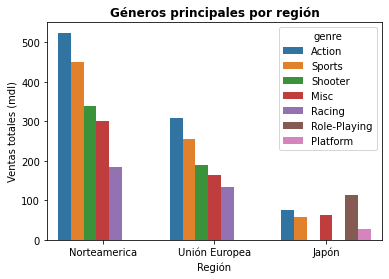

In [41]:
# Distribución de ventas por plataforma por región
sns.barplot(data= region_genre2, x= 'market', y= 'sales', hue= 'genre')

plt.title('Géneros principales por región', fontweight='bold')
plt.xlabel('Región')
plt.ylabel('Ventas totales (mdl)')

ax = plt.gca()
ax.set_xticklabels(new_xtick)

plt.show()

Tanto en Norteamerica como en la Union Europea los cinco generos con mas ventas son: Acción, Deportes, Disparos, Miscelaneos y Carreras en ese orden.
<br> Para Japón, el mercado prefiere como primera opción los Juegos de Rol, género que no se observa en las otras dos regiones; los juegos de acción, miscelaneos y deportes también forman parte de las principales plataformas en Japon en ese orden de ventas, sin embargo a esta lista tambien se agregan los juegos de plataforma, dejando de lado los juegos de disparos y carreras en esta región.    

### 4.3 Clasificación ESRB y ventas 

In [42]:
# Raiting por region y sus ventas
region_rating= top_platforms.groupby(by= 'rating').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum', 'name': 'count'}).reset_index()

# Invertir el dataframe a formato largo y establecer los identificadores por region
region_rating2 = pd.melt(region_rating, id_vars= 'rating', value_vars = ['na_sales', 'eu_sales', 'jp_sales'], var_name= 'market', value_name= 'sales')

region_rating

,rating,na_sales,eu_sales,jp_sales,name
0,E,896.81,495.13,127.81,2393
1,E10+,271.83,133.11,28.41,934
2,EC,1.35,0.09,0.00,5
3,M,544.96,319.00,45.60,825
4,T,495.24,256.69,86.49,1603


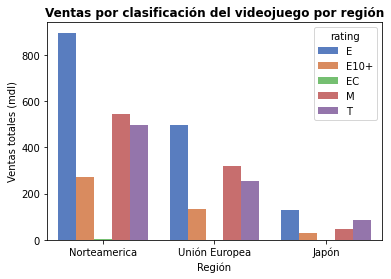

In [43]:
# Distribución de ventas por clasificación y por región
sns.barplot(data= region_rating2, x= 'market', y= 'sales', hue= 'rating', palette='muted') 

plt.title('Ventas por clasificación del videojuego por región', fontweight='bold')
plt.xlabel('Región')
plt.ylabel('Ventas totales (mdl)')

ax = plt.gca()
ax.set_xticklabels(new_xtick)

plt.show()

En Norteamérica, los videojuegos con una clasificación “E” tienen las ventas más altas, superando significativamente a otras clasificaciones.
En la Unión Europea, las ventas están más distribuidas entre los juegos con clasificación “E”, “E10+” y “M”.
En Japón, los juegos con clasificación “T” lideran en ventas, aunque con un margen menor al de la dominancia de los juegos con clasificación “E” en Norteamérica.
Solo se han tenido ventas de videojuegos clasificación EC en Norteamerica y la Unión Europea pero estas son mínimas. 

### Conclusiones Parte 4. Perfil por region
El análisis de las ventas de videojuegos revela patrones distintivos en diferentes regiones del mundo. En Norteamérica, las plataformas X360 y PS2 lideran las ventas, seguidas de cerca por la consola Wii, mientras que las ventas de PS3 y DS son las más bajas. En la Unión Europea, la familia PlayStation domina el mercado, con PS2 y PS3 generando ingresos significativos. En Japón, las preferencias son diferentes, con la plataforma DS y PS2 encabezando las ventas, y una escasa presencia de X360. En cuanto a los géneros más populares, Norteamérica y la Unión Europea muestran preferencia por Acción, Deportes, Disparos, Misceláneos y Carreras, mientras que Japón se inclina por los Juegos de Rol, seguidos de cerca por Acción, Misceláneos y Deportes, y con una notable ausencia de juegos de disparos y carreras. Respecto a las clasificaciones de edad, en Norteamérica, los juegos con clasificación “E” lideran las ventas, mientras que en la Unión Europea, la distribución es más equitativa entre “E”, “E10+” y “M”. En Japón, los juegos clasificados como “T” son los más populares, aunque con una diferencia menor respecto a los juegos clasificados como “E”. Estos análisis destacan las diferencias culturales y de preferencias que influyen en el mercado global de videojuegos.

## 5. Pruebas de hipótesis 

Probar las siguientes hipótesis:
1. Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.
2. Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

### 5.1 Hipótesis 1

Las calificaciones promedio de los usuarios de las plataformas Xbox One y PC son las mismas.

**Hipótesis nula:** Las calificaciones promedio de los usuarios de las plataformas Xbox One y PC son las mismas.
<br> **Hipótesis alternativa:** Las calificaciones promedio de los usuarios de las plataformas Xbox One y PC son diferentes.

In [44]:
# Filtrar los datos para las plataformas Xbox One y PC
score_xbox = games[games['platform'] == 'XOne']['user_score'].dropna()
score_pc = games[games['platform'] == 'PC']['user_score'].dropna()

# Realizar el test de hipótesis
stat, p_value = ttest_ind(score_xbox, score_pc)

# Imprimir los valores
print(f"""
    Calificación promedio de los usuarios de Xbox One: {score_xbox.mean()}
    Calificación promedio de los usuarios de PC: {score_pc.mean()}
      
    t-statistic: {stat}
    p-value: {p_value}
""")

# Comprobar si se rechaza la hipótesis nula
alfa = 0.05
if p_value < alfa:
    print(f"""Podemos rechazar la hipótesis nula
    Las calificaciones promedio de Xbox One y PC son diferentes. """)
else:
    print(f"""No podemos rechazar la hipótesis nula
    Las calificaciones promedio de Xbox One y PC son iguales. """)



    Calificación promedio de los usuarios de Xbox One: 6.521428571428572
    Calificación promedio de los usuarios de PC: 7.062467532467533
      
    t-statistic: -4.368333815003015
    p-value: 1.3896435533548819e-05

Podemos rechazar la hipótesis nula
    Las calificaciones promedio de Xbox One y PC son diferentes. 


La hipotesis nula y alternativa se formularon en base a la relación que expresa la hipotesis géneral entre las dos plataformas, siendo la H0 la que debe expresar igualdad y la H1 contraria a todo lo que exprese la hipotesis nula. 
<br> Para comprobar esta hipótesis, se utilizó el test de hipótesis estadístico t de Student que evalua dos muestras independientes, una muestra de las calificaciones de XboxOne y otra para PC. 

El análisis comprobó que las calificaciones promedio de los usuarios entre las plataformas Xbox One y PC no son iguales. PC tiene una mejor calificación promedio que Xbox One. El valor p del test de hipótesis es muy pequeño (1.3896435533548819e-05), lo que indica una evidencia fuerte en contra de la hipótesis nula.

### 5.2 Hipotesis 2
Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

**Hipótesis nula:** Las calificaciones promedio de los usuarios para los géneros Acción y Deportes son las mismas.
<br> **Hipótesis alternativa:** Las calificaciones promedio de los usurios para los géneros Acción y Deportes son diferentes.

In [45]:
# Filtrar los datos para las plataformas Xbox One y PC
score_action = games[games['genre'] == 'Action']['user_score'].dropna()
score_sports = games[games['genre'] == 'Sports']['user_score'].dropna()

# Realizar el test de hipótesis
stat2, p_value2 = ttest_ind(score_action, score_sports)

# Imprimir los valores
print(f"""
    Calificación promedio de los usuarios de videojuegos del género Acción: {score_action.mean()}
    Calificación promedio de los usuarios de videojuegos del género Deportes: {score_sports.mean()}
      
    t-statistic: {stat2}
    p-value: {p_value2}
""")

# Comprobar si se rechaza la hipótesis nula
alfa = 0.05
if p_value2 < alfa:
    print(f"""Podemos rechazar la hipótesis nula
    Las calificaciones promedio de los géneros Acción y Deportes son diferentes. """)
else:
    print(f"""No podemos rechazar la hipótesis nula
    Las calificaciones promedio de los géneros Acción y Deportes son iguales. """)


    Calificación promedio de los usuarios de videojuegos del género Acción: 7.054043715846995
    Calificación promedio de los usuarios de videojuegos del género Deportes: 6.961196736174069
      
    t-statistic: 1.6259419280500857
    p-value: 0.10406951359049141

No podemos rechazar la hipótesis nula
    Las calificaciones promedio de los géneros Acción y Deportes son iguales. 


La hipotesis nula y alternativa se formularon en base a la relación que expresa la hipotesis géneral entre los dos géneros; la H0 es la que debe expresar igualdad y la H1 lo contrario a todo lo que exprese la hipotesis nula. En este caso, nuestro objetivo es rechazar la hipotesis nula. 
<br> Para comprobar esta hipótesis, se utilizó el test de hipótesis estadístico t de Student que evalua dos muestras independientes, una muestra de las calificaciones del género Acció y otra de PC. 

Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes no muestran una diferencia estadísticamente significativa.
El valor p del test es 0.10406951359049141, lo que indica que no hay suficiente evidencia para rechazar la hipótesis nula a un nivel de significancia del 0.05.
<br> Es importante considerar que, aunque el resultado no mostró una diferencia estadísticamente significativa, aún puede haber diferencias en las preferencias de los usuarios entre los géneros de Acción y Deportes. Sin embargo, en base a este análisis específico, no podemos afirmar con certeza que estas diferencias sean estadísticamente significativas

## Conclusión 
Se recibió un dataset con la información de las ventas de videojuegos de la tienda online Ice, se hizo limpieza y preparación de los datos y en este punto se tomo la decisión de dejar en blanco los valores ausentes de 3 columnas debido a que representaban mas del 40% de los datos y remplazarlos crearía un sesgo en el analisis.
Para el análisis se tomó la decisión de tomar en cuenta unicamente los datos de videojuegos lanzados a partir del año 2000 en adelante, periodo en el que se observa el mayor crecimiento y que aporta mayor información para prospecciones del próximo año 2017.

Este análisis mostró que las plataformas más exitosas en términos de ventas totales son PS2, X360, PS3, Wii y DS, aunque todas ellas han experimentado una tendencia decreciente en los últimos años. Destaca especialmente el potencial continuo de las plataformas de PlayStation, sugiriendo oportunidades prometedoras para futuros lanzamientos. Los años entre 2005 y 2010 fueron los más prolíficos en términos de lanzamientos de videojuegos al mercado y se identificó que el ciclo de vida promedio de cada plataforma a partir de su lanzamiento es de máximo 5 años.

La correlación moderadamente positiva entre las ventas totales y las reseñas de los críticos sugiere que las opiniones profesionales pueden influir en las ventas, aunque las reseñas de los usuarios tienen una correlación más débil. Al comparar las mismas entregas de videojuegos en diferentes plataformas, se revela que las ventas varían significativamente según la plataforma, mostrando que la plataforma X360 ha sido la más consistente en ventas. 
<br> Los géneros más populares y rentables incluyen Acción, Deportes, Disparos y Carreras, aunque la presencia de valores atípicos en algunos géneros resalta la necesidad de una comprensión más profunda de las tendencias del mercado.

El análisis de las ventas de videojuegos revela algunos patrones regionales. En Norteamérica, X360 y PS2 lideran, seguidas por Wii, con ventas bajas de PS3 y DS. En la Unión Europea, PlayStation domina con PS2 y PS3. En Japón, DS y PS2 lideran, con escasa presencia de X360. Los géneros más populares varían; Norteamérica y la Unión Europea prefieren Acción, Deportes, Disparos, Misceláneos y Carreras, mientras que Japón prefiere Juegos de Rol, Acción y Misceláneos. En clasificaciones de edad, “E” lidera en Norteamérica, “E”, “E10+” y “M” en la Unión Europea, y “T” en Japón, evidenciando influencias culturales en el mercado global de videojuegos.

Se comprobó que las calificaciones promedio de los usuarios entre las plataformas Xbox One y PC no son iguales. PC tiene una mejor calificación promedio que Xbox One, respaldado con un valor p del test de hipótesis que indica una evidencia fuerte. Además, las calificaciones promedio de los usuarios para los géneros de Acción y Deportes no muestran una diferencia estadísticamente significativa, esto junto con la tendencia de ser ambos los géneros con mas ventas en al menos dos regiones, da pie a considerarlos como géneros rentables. 




<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b>
<h1>    Comentarios Generales </h1>
Felicidades has aprobado, has hecho un excelente trabajo te felicito.      
</div>

